In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import numpy as np
import pandas as pd
import os
import sys
import cv2
from tqdm.auto import tqdm 
import shutil


In [6]:
'''from ..utils_DP import bb_intersection_over_union'''
# if you get the error: ImportError: attempted relative import with no known parent package
# https://iq-inc.com/importerror-attempted-relative-import/


'from ..utils_DP import bb_intersection_over_union'

In [7]:
from utils_DP import get_bbox_area, get_bbox_height, get_bbox_width, get_bbox_aspect_ratio

In [8]:
base_dir = os.path.join('..', '..')
dataset = 'Dataset'
dataset_dir = os.path.join(base_dir, dataset)

### 1. Read csv file

In [15]:
df_train = pd.read_csv(os.path.join(dataset_dir, "train_downsampled.csv"))
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [16]:
df_train.rad_id.unique()

array(['R11', 'R7', 'R10', 'R9', 'R17', 'R3', 'R8', 'R6', 'R5', 'R4',
       'R2', 'R16', 'R1', 'R15', 'R13', 'R12', 'R14'], dtype=object)

In [17]:
# prepare directory for train and test image
train = os.path.join("train", "train")
test = os.path.join("test", "test")
train_dir = os.path.join(dataset_dir, train)
test_dir = os.path.join(dataset_dir, test)

In [18]:
df_train["image_path"] = df_train["image_id"].map(lambda x: os.path.join(train_dir, x + ".jpg"))

In [19]:
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\50a418190bc3fb1ef163...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\21a10246a5ec7af15108...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\..\Dataset\train\train\9a5094b2563a1ef3ff50...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\..\Dataset\train\train\051132a778e61a86eb14...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\063319de25ce7edb9b1c...


In [20]:
df_finding_train = df_train[df_train.class_id != 14]
df_non_finding_train = df_train[df_train.class_id == 14]

In [21]:
num_imgs_positive_train = len(df_finding_train["image_id"].unique())
num_imgs_negative_train = len(df_non_finding_train["image_id"].unique())
print(f"num_imgs_positive_train = {num_imgs_positive_train}")
print(f"num_imgs_negative_train = {num_imgs_negative_train}")
print(f"Total = {num_imgs_positive_train + num_imgs_negative_train}")

num_imgs_positive_train = 4394
num_imgs_negative_train = 10606
Total = 15000


In [22]:
x = df_finding_train[["class_name", "class_id"]].groupby(by = ["class_name", "class_id"]).count().reset_index()
dct_class_ids = {}
for i in x.to_numpy():
  dct_class_ids[i[0]] = int(i[1])
dct_class_ids["No finding"] = 14

dct_class_ids

{'Aortic enlargement': 0,
 'Atelectasis': 1,
 'Calcification': 2,
 'Cardiomegaly': 3,
 'Consolidation': 4,
 'ILD': 5,
 'Infiltration': 6,
 'Lung Opacity': 7,
 'Nodule/Mass': 8,
 'Other lesion': 9,
 'Pleural effusion': 10,
 'Pleural thickening': 11,
 'Pneumothorax': 12,
 'Pulmonary fibrosis': 13,
 'No finding': 14}

In [23]:
def GetKey(val):
   for key, value in dct_class_ids.items():
      if val == value:
        
        return key
      continue

### 2. Calculate Bounding box area

In [24]:
df_finding_train["bbox_area"] = df_finding_train.apply(get_bbox_area, axis =  1)

<ipython-input-24-fb230a8950e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finding_train["bbox_area"] = df_finding_train.apply(get_bbox_area, axis =  1)


In [25]:
df_finding_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path,bbox_area
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\..\Dataset\train\train\9a5094b2563a1ef3ff50...,48792.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\..\Dataset\train\train\051132a778e61a86eb14...,10672.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,209.0,119.0,315.0,144.0,..\..\Dataset\train\train\1c32170b4af4ce1a3030...,2650.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,449.0,81.0,729.0,723.0,..\..\Dataset\train\train\0c7a38f293d5f5e4846a...,179760.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,185.0,784.0,225.0,828.0,..\..\Dataset\train\train\47ed17dcb2cbeec15182...,1760.0


In [26]:
# mean of bbox for each classes (before normalize image's size)
mean_bbox_area = dict()
for i in range(14):
  series = df_finding_train[df_finding_train.class_id == i].bbox_area.describe()
  print(f"class id = {i} with the mean of bbox area = {series[5]}")
  mean_bbox_area[i] = series[5]
  print()

class id = 0 with the mean of bbox area = 10710.0

class id = 1 with the mean of bbox area = 30408.0

class id = 2 with the mean of bbox area = 3035.0

class id = 3 with the mean of bbox area = 43992.0

class id = 4 with the mean of bbox area = 26245.0

class id = 5 with the mean of bbox area = 61543.0

class id = 6 with the mean of bbox area = 27183.0

class id = 7 with the mean of bbox area = 16896.0

class id = 8 with the mean of bbox area = 1110.0

class id = 9 with the mean of bbox area = 13209.0

class id = 10 with the mean of bbox area = 6962.0

class id = 11 with the mean of bbox area = 3523.0

class id = 12 with the mean of bbox area = 59159.0

class id = 13 with the mean of bbox area = 8436.0



In [27]:
# get mean bbox area of each class
df = pd.DataFrame({"class_id": mean_bbox_area.keys(), 
                   "class_name": [GetKey(i) for i in mean_bbox_area.keys()],
                   "mean_bb_area": mean_bbox_area.values()})
df = df.sort_values(by = "mean_bb_area", ascending= False)

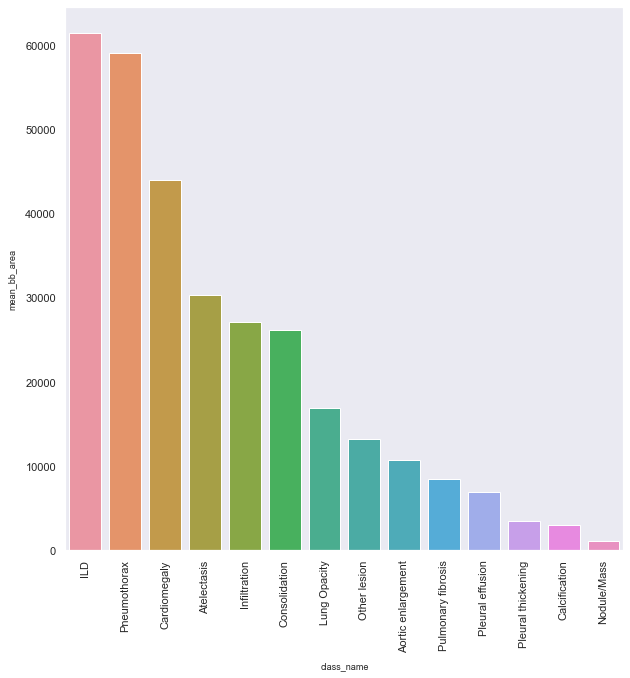

In [28]:
plt.figure(figsize = (10,10))
sns.barplot(data = df, x = df["class_name"], y = df["mean_bb_area"])
plt.xticks(rotation = 90)
plt.show()

### 3. Get the image's heigh and width

In [29]:
imgs_path = df_train.image_path.unique()

In [30]:
img_array = cv2.imread(imgs_path[0])
print(img_array.shape)
# height = 860, width = 777, channel = 3

(860, 777, 3)


In [ ]:
# save all the image's height and width into 2 lists
lst_imgs_height = list()
lst_imgs_width = list()
for img_path in tqdm(imgs_path, total = len(imgs_path)):
  img_array = cv2.imread(img_path)
  #print(f"img_id = {Path(img_path).stem}")
  lst_imgs_height.append(int(img_array.shape[0]))
  lst_imgs_width.append(int(img_array.shape[1]))
  #print()
print ('Done')

  0%|          | 0/15000 [00:00<?, ?it/s]

In [33]:
df_img_size = pd.DataFrame({"image_path": imgs_path,
                            "image_height": lst_imgs_height,
                            "image_width": lst_imgs_width})


In [34]:
df_train["image_height"] = df_train.image_path.map(lambda x: df_img_size[df_img_size.image_path == x]["image_height"].values[0])
df_train["image_width"] = df_train.image_path.map(lambda x: df_img_size[df_img_size.image_path == x]["image_width"].values[0])
print("DONE")

DONE


In [36]:
df_train["bbox_area"] = df_train.apply(get_bbox_area, axis = 1)
df_train["bbox_height"] = df_train.apply(get_bbox_height, axis = 1)
df_train["bbox_width"] = df_train.apply(get_bbox_width, axis = 1)
df_train["bbox_ratio_w/h"] = df_train.apply(get_bbox_aspect_ratio, axis = 1)

In [40]:
df_train["xmin_norm"] = df_train["x_min"] / df_train["image_width"]
df_train["ymin_norm"] = df_train["y_min"] / df_train["image_height"]
df_train["xmax_norm"] = df_train["x_max"] / df_train["image_width"]
df_train["ymax_norm"] = df_train["y_max"] / df_train["image_height"]

In [41]:
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path,image_height,image_width,bbox_area,bbox_height,bbox_width,bbox_ratio_w/h,xmin_norm,ymin_norm,xmax_norm,ymax_norm
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\50a418190bc3fb1ef163...,860,777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\21a10246a5ec7af15108...,1053,984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\..\Dataset\train\train\9a5094b2563a1ef3ff50...,778,693,48792.0,152.0,321.0,2.112,0.331890,0.588689,0.795094,0.784062
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\..\Dataset\train\train\051132a778e61a86eb14...,960,768,10672.0,92.0,116.0,1.261,0.548177,0.257292,0.699219,0.353125
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\063319de25ce7edb9b1c...,1024,846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_finding_train = df_train[df_train.class_id != 14]
df_non_finding_train = df_train[df_train.class_id == 14]

In [43]:
heatmap_size = (500,400)
bbox_heatmap = df_finding_train[[ "class_id","xmin_norm", "ymin_norm", "xmax_norm", "ymax_norm"]]
bbox_heatmap["xmin_norm"] = bbox_heatmap["xmin_norm"] * heatmap_size[1]
bbox_heatmap["xmax_norm"] = bbox_heatmap["xmax_norm"] * heatmap_size[1]
bbox_heatmap["ymin_norm"] = bbox_heatmap["ymin_norm"] * heatmap_size[0]
bbox_heatmap["ymax_norm"] = bbox_heatmap["ymax_norm"] * heatmap_size[0]
bbox_heatmap = bbox_heatmap.astype(int)

<ipython-input-43-995f8e7b0a44>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_heatmap["xmin_norm"] = bbox_heatmap["xmin_norm"] * heatmap_size[1]
<ipython-input-43-995f8e7b0a44>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_heatmap["xmax_norm"] = bbox_heatmap["xmax_norm"] * heatmap_size[1]
<ipython-input-43-995f8e7b0a44>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [47]:
def draw_bbox_on_heatmap(bboxes, class_id, heatmap_size):
    # initialize empty (full black) heatmap
    heatmap = np.zeros((heatmap_size))
    for _, row in bboxes[bboxes["class_id"] == class_id].iterrows():
        # draw white bboxes on black heatmap based on bboxes coordinate
        # that mean multiple bboxes which same class_id will be drawn on same heatmap
        heatmap[row[2]:row[4], row[1]:row[3]] += 1
    return heatmap

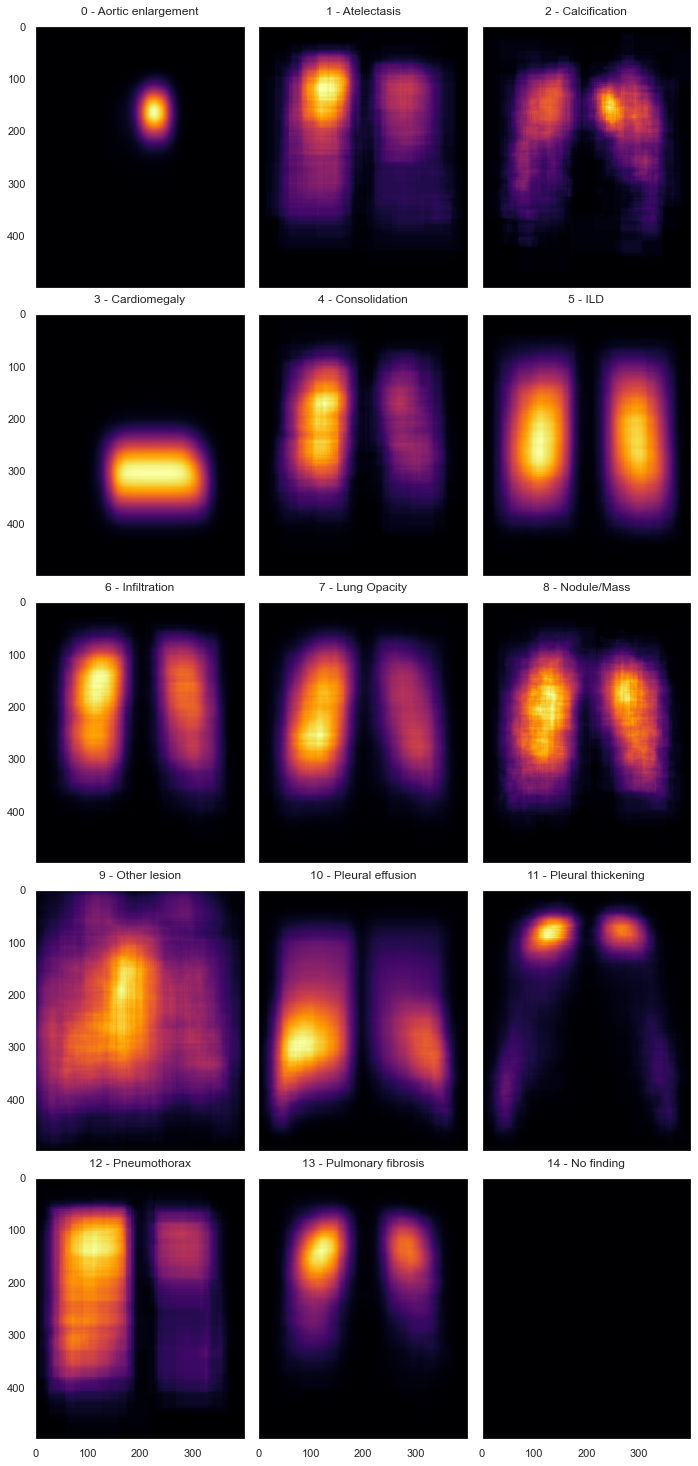

In [48]:
fig, axes = plt.subplots(nrows=5, ncols=3, sharey=True, sharex=True, 
                         gridspec_kw={'hspace': .1, 'wspace': 0}, figsize=(12, 26))

for i, ax in enumerate(axes.flatten()):
    # display heatmap
    ax.imshow(draw_bbox_on_heatmap(bbox_heatmap, i, heatmap_size),
              cmap="inferno", interpolation='nearest')
    # set title for heatmap
    _ = ax.set_title(str(i) + ' - ' + GetKey(i), size=12)


#plt.savefig(os.path.join(chart_path, "13.Heat_map.png"))
plt.show()

### 4. Save file

In [17]:
Intermediates_dir = os.path.join('..', 'Intermediates')
Charts_Images_dir = os.path.join(Intermediates_dir, 'Charts_Images')
csv_txt_json_data = os.path.join(Intermediates_dir, 'csv_txt_json_data')

In [51]:
# save entire infomation dataset
df_train.to_csv(os.path.join(csv_txt_json_data, "dataset_after_processing.csv"))
# save image size
df_img_size.to_csv(os.path.join(csv_txt_json_data, "image_size.csv"))

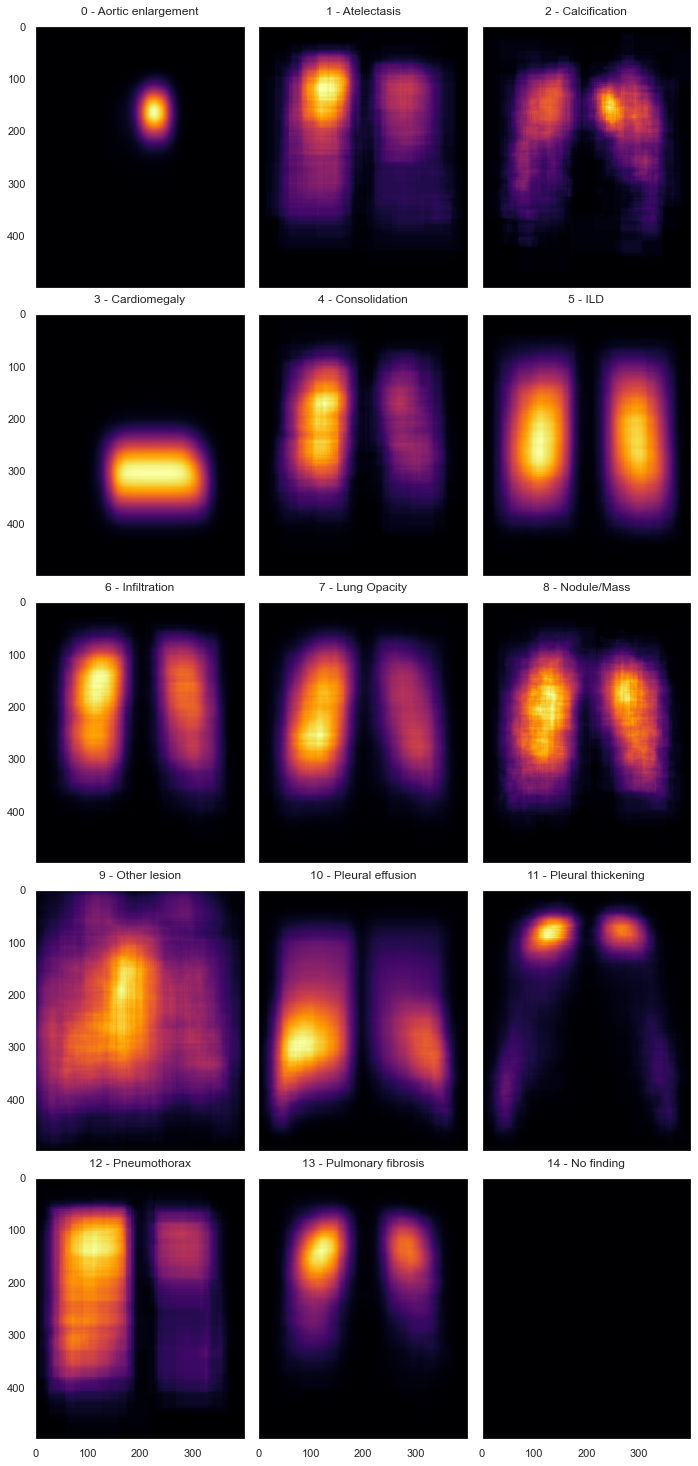

In [52]:
# save heart map
fig, axes = plt.subplots(nrows=5, ncols=3, sharey=True, sharex=True, 
                         gridspec_kw={'hspace': .1, 'wspace': 0}, figsize=(12, 26))

for i, ax in enumerate(axes.flatten()):
    # display heatmap
    ax.imshow(draw_bbox_on_heatmap(bbox_heatmap, i, heatmap_size),
              cmap="inferno", interpolation='nearest')
    # set title for heatmap
    _ = ax.set_title(str(i) + ' - ' + GetKey(i), size=12)


plt.savefig(os.path.join(Charts_Images_dir, "Heat_map.png"))
#plt.show()

### Compliments

In [11]:
df_train = pd.read_csv('../Intermediates/csv_txt_json_data/dataset_after_processing.csv', index_col = 0)

In [12]:
df_train

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path,image_height,image_width,bbox_area,bbox_height,bbox_width,bbox_ratio_w/h,xmin_norm,ymin_norm,xmax_norm,ymax_norm
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\50a418190bc3fb1ef163...,860,777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\21a10246a5ec7af15108...,1053,984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\..\Dataset\train\train\9a5094b2563a1ef3ff50...,778,693,48792.0,152.0,321.0,2.112,0.331890,0.588689,0.795094,0.784062
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\..\Dataset\train\train\051132a778e61a86eb14...,960,768,10672.0,92.0,116.0,1.261,0.548177,0.257292,0.699219,0.353125
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\063319de25ce7edb9b1c...,1024,846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\936fd5cff1c058d39817...,1066,814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\ca7e72954550eeb610fe...,810,664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,..\..\Dataset\train\train\aa17d5312a0fb4a29394...,833,682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,257.0,326.0,560.0,437.0,..\..\Dataset\train\train\4b56bc6d22b192f075f1...,680,656,33633.0,111.0,303.0,2.730,0.391768,0.479412,0.853659,0.642647


In [19]:
train = os.path.join("train", "train")
base_new = os.path.join('..','Dataset')
train_dir_new = os.path.join(base_new, train)
train_dir_new

'..\\Dataset\\train\\train'

In [20]:
df_train["image_path"] = df_train["image_id"].map(lambda x: os.path.join(train_dir_new, x + ".jpg"))

In [21]:
df_train

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,image_path,image_height,image_width,bbox_area,bbox_height,bbox_width,bbox_ratio_w/h,xmin_norm,ymin_norm,xmax_norm,ymax_norm
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,..\Dataset\train\train\50a418190bc3fb1ef1633bf...,860,777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,..\Dataset\train\train\21a10246a5ec7af151081d0...,1053,984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,230.0,458.0,551.0,610.0,..\Dataset\train\train\9a5094b2563a1ef3ff50dc5...,778,693,48792.0,152.0,321.0,2.112,0.331890,0.588689,0.795094,0.784062
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,421.0,247.0,537.0,339.0,..\Dataset\train\train\051132a778e61a86eb147c7...,960,768,10672.0,92.0,116.0,1.261,0.548177,0.257292,0.699219,0.353125
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,..\Dataset\train\train\063319de25ce7edb9b1c6b8...,1024,846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,..\Dataset\train\train\936fd5cff1c058d39817a08...,1066,814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,..\Dataset\train\train\ca7e72954550eeb610fe22b...,810,664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,..\Dataset\train\train\aa17d5312a0fb4a2939436a...,833,682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,257.0,326.0,560.0,437.0,..\Dataset\train\train\4b56bc6d22b192f075f1323...,680,656,33633.0,111.0,303.0,2.730,0.391768,0.479412,0.853659,0.642647


In [22]:
df_train.to_csv(os.path.join(csv_txt_json_data, "dataset_after_processing_1.csv"))